# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 22, 1, 19, 35, 187775)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
with open('../../data/hopsworkKey.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1170584
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='9.572286E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [7]:
retrieved_model_2 = mr.get_model(
    name="air_quality_xgboost_model_3",
    version=5,
)

# Download the saved model artifacts to a local directory
saved_model_dir_2 = retrieved_model_2.download()

In [8]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model_2 = XGBRegressor()

retrieved_xgboost_model_2.load_model(saved_model_dir_2 + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model_2

XGBRegressor(base_score='9.6353134E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [9]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.93s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-23 00:00:00+00:00,12.40,0.1,5.351785,19.653913,chengdu
1,2024-11-24 00:00:00+00:00,10.15,0.4,12.397806,25.820946,chengdu
2,2024-11-25 00:00:00+00:00,9.55,0.0,1.440000,270.000000,chengdu
3,2024-11-26 00:00:00+00:00,9.15,0.0,9.387651,57.528828,chengdu
4,2024-11-27 00:00:00+00:00,7.55,0.0,6.130579,3.366400,chengdu
5,2024-11-28 00:00:00+00:00,9.50,0.0,4.104631,15.255177,chengdu
6,2024-11-29 00:00:00+00:00,10.05,0.0,4.896529,17.102825,chengdu
7,2024-11-30 00:00:00+00:00,11.10,0.0,8.280000,360.000000,chengdu


## <span style="color:#ff5f27;">✨ Get AQ   </span>

In [10]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_fg


In [11]:
date_search = today- datetime.timedelta(days=4)
date_search

datetime.datetime(2024, 11, 18, 1, 19, 35, 187775)

In [12]:
date_search = today- datetime.timedelta(days=4)
air_quality_df = air_quality_fg.filter(air_quality_fg.date >= date_search).read()
air_quality_df = air_quality_df.sort_values(by=['date'])
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.96s) 


,date,pm25,country,city,street,url
0,2024-11-19 00:00:00+00:00,68.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
1,2024-11-20 00:00:00+00:00,50.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
2,2024-11-21 00:00:00+00:00,87.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [13]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-11-23 00:00:00+00:00,12.40,0.1,5.351785,19.653913,chengdu,109.713249
1,2024-11-24 00:00:00+00:00,10.15,0.4,12.397806,25.820946,chengdu,146.239822
2,2024-11-25 00:00:00+00:00,9.55,0.0,1.440000,270.000000,chengdu,149.946060
3,2024-11-26 00:00:00+00:00,9.15,0.0,9.387651,57.528828,chengdu,147.038727
4,2024-11-27 00:00:00+00:00,7.55,0.0,6.130579,3.366400,chengdu,133.487976
5,2024-11-28 00:00:00+00:00,9.50,0.0,4.104631,15.255177,chengdu,166.097076
6,2024-11-29 00:00:00+00:00,10.05,0.0,4.896529,17.102825,chengdu,156.627502
7,2024-11-30 00:00:00+00:00,11.10,0.0,8.280000,360.000000,chengdu,105.952202


In [14]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      object             
 6   predicted_pm25               8 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 416.0+ bytes


### <span style="color:#ff5f27;">🤖 Get pm25_rolling_mean And Predict</span>

In [15]:

new_df = batch_data.copy()
new_df.rename(columns={'predicted_pm25': 'pm25_rolling_mean'}, inplace=True)



new_df.loc[0, 'pm25_rolling_mean'] = air_quality_df.iloc[0]['pm25'] + air_quality_df.iloc[1]['pm25']+ air_quality_df.iloc[2]['pm25']/3
new_df.loc[1, 'pm25_rolling_mean'] = batch_data.iloc[0]['predicted_pm25'] + air_quality_df.iloc[1]['pm25']+ air_quality_df.iloc[2]['pm25']/3
new_df.loc[2, 'pm25_rolling_mean'] = batch_data.iloc[0]['predicted_pm25'] + batch_data.iloc[1]['predicted_pm25']+ air_quality_df.iloc[2]['pm25']/3

new_df_2 = batch_data.copy()
new_df_2['pm25_rolling_mean'] = batch_data['predicted_pm25'].shift(1).rolling(window=3).mean()


new_df.loc[3:, 'pm25_rolling_mean'] = new_df_2.loc[3:, 'pm25_rolling_mean']
# new_df
new_df

2024-11-22 01:19:53,779 WARNING: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[135.29971059 147.74153646 143.49092102 148.8745931  152.07085164]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.



,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling_mean
0,2024-11-23 00:00:00+00:00,12.40,0.1,5.351785,19.653913,chengdu,147.000000
1,2024-11-24 00:00:00+00:00,10.15,0.4,12.397806,25.820946,chengdu,188.713257
2,2024-11-25 00:00:00+00:00,9.55,0.0,1.440000,270.000000,chengdu,284.953064
3,2024-11-26 00:00:00+00:00,9.15,0.0,9.387651,57.528828,chengdu,135.299711
4,2024-11-27 00:00:00+00:00,7.55,0.0,6.130579,3.366400,chengdu,147.741536
5,2024-11-28 00:00:00+00:00,9.50,0.0,4.104631,15.255177,chengdu,143.490921
6,2024-11-29 00:00:00+00:00,10.05,0.0,4.896529,17.102825,chengdu,148.874593
7,2024-11-30 00:00:00+00:00,11.10,0.0,8.280000,360.000000,chengdu,152.070852


In [16]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      object             
 6   pm25_rolling_mean            8 non-null      float64            
dtypes: datetime64[us, UTC](1), float32(4), float64(1), object(1)
memory usage: 448.0+ bytes


In [17]:
new_df['predicted_pm25'] = retrieved_xgboost_model_2.predict(
    new_df[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant','pm25_rolling_mean']])
new_df

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling_mean,predicted_pm25
0,2024-11-23 00:00:00+00:00,12.40,0.1,5.351785,19.653913,chengdu,147.000000,136.314301
1,2024-11-24 00:00:00+00:00,10.15,0.4,12.397806,25.820946,chengdu,188.713257,185.309128
2,2024-11-25 00:00:00+00:00,9.55,0.0,1.440000,270.000000,chengdu,284.953064,183.473755
3,2024-11-26 00:00:00+00:00,9.15,0.0,9.387651,57.528828,chengdu,135.299711,124.173065
4,2024-11-27 00:00:00+00:00,7.55,0.0,6.130579,3.366400,chengdu,147.741536,153.921082
5,2024-11-28 00:00:00+00:00,9.50,0.0,4.104631,15.255177,chengdu,143.490921,143.206360
6,2024-11-29 00:00:00+00:00,10.05,0.0,4.896529,17.102825,chengdu,148.874593,131.546295
7,2024-11-30 00:00:00+00:00,11.10,0.0,8.280000,360.000000,chengdu,152.070852,125.595650


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [18]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# # Fill in the number of days before the date on which you made the forecast (base_date)
# batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country
0,2024-11-23 00:00:00+00:00,12.40,0.1,5.351785,19.653913,chengdu,109.713249,chengdu-jinbo-road,china
1,2024-11-24 00:00:00+00:00,10.15,0.4,12.397806,25.820946,chengdu,146.239822,chengdu-jinbo-road,china
2,2024-11-25 00:00:00+00:00,9.55,0.0,1.440000,270.000000,chengdu,149.946060,chengdu-jinbo-road,china
3,2024-11-26 00:00:00+00:00,9.15,0.0,9.387651,57.528828,chengdu,147.038727,chengdu-jinbo-road,china
4,2024-11-27 00:00:00+00:00,7.55,0.0,6.130579,3.366400,chengdu,133.487976,chengdu-jinbo-road,china
5,2024-11-28 00:00:00+00:00,9.50,0.0,4.104631,15.255177,chengdu,166.097076,chengdu-jinbo-road,china
6,2024-11-29 00:00:00+00:00,10.05,0.0,4.896529,17.102825,chengdu,156.627502,chengdu-jinbo-road,china
7,2024-11-30 00:00:00+00:00,11.10,0.0,8.280000,360.000000,chengdu,105.952202,chengdu-jinbo-road,china


In [19]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      object             
 6   predicted_pm25               8 non-null      float32            
 7   street                       8 non-null      object             
 8   country                      8 non-null      object             
dtypes: datetime64[us, UTC](1), float32(5), object(3)
memory usage: 544.0+ bytes


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

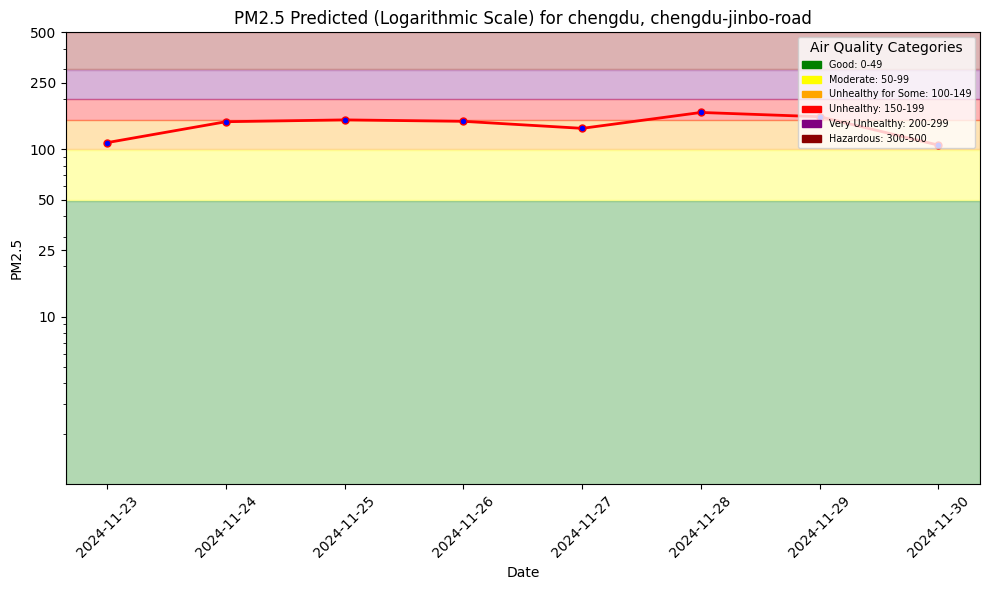

In [20]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

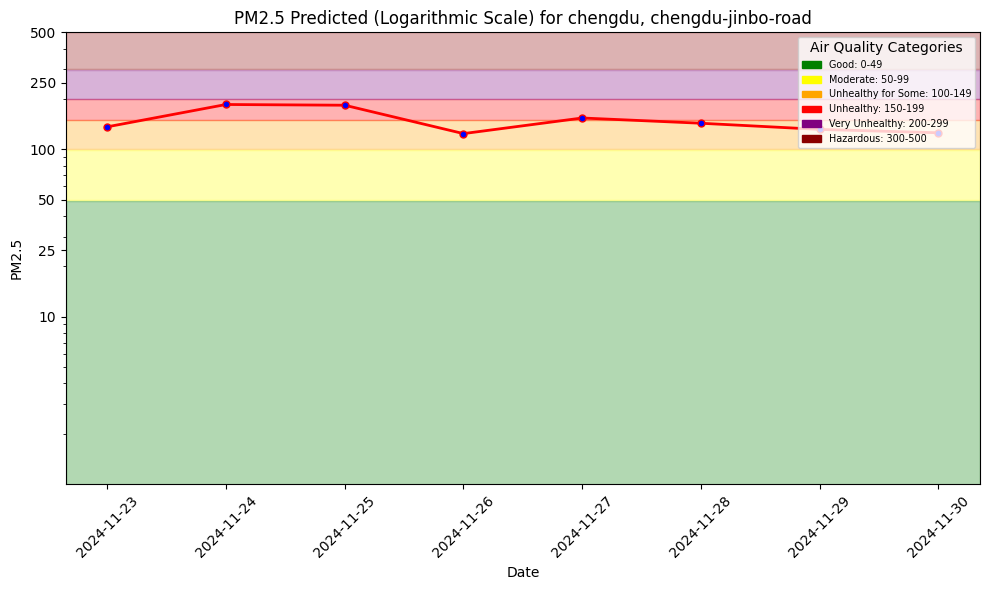

In [21]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast_with_rolling.png"
plt = util.plot_air_quality_forecast(city, street, new_df, file_path)
plt.show()

In [22]:
# # del the fg
# fs = project.get_feature_store()
# util.delete_feature_groups(fs, "aq_predictions")

In [23]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date'],
    event_time="date"
)

In [24]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/8 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1170584/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x211c4dc8c70>, None)

In [25]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
# monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df = monitor_fg.read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.80s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country
0,2024-11-20 00:00:00+00:00,12.95,0.0,2.595997,56.309914,chengdu,144.470337,chengdu-jinbo-road,china
1,2024-11-25 00:00:00+00:00,9.55,0.0,1.440000,270.000000,chengdu,149.946060,chengdu-jinbo-road,china
2,2024-11-24 00:00:00+00:00,10.15,0.4,12.397806,25.820946,chengdu,146.239822,chengdu-jinbo-road,china
3,2024-11-26 00:00:00+00:00,9.15,0.0,9.387651,57.528828,chengdu,147.038727,chengdu-jinbo-road,china
4,2024-11-23 00:00:00+00:00,12.40,0.1,5.351785,19.653913,chengdu,109.713249,chengdu-jinbo-road,china
5,2024-11-21 00:00:00+00:00,12.65,0.0,3.096837,35.537766,chengdu,152.536270,chengdu-jinbo-road,china
6,2024-11-22 00:00:00+00:00,13.75,0.0,2.741678,23.198618,chengdu,87.159050,chengdu-jinbo-road,china
7,2024-11-27 00:00:00+00:00,7.55,0.0,6.130579,3.366400,chengdu,133.487976,chengdu-jinbo-road,china
8,2024-11-28 00:00:00+00:00,9.50,0.0,4.104631,15.255177,chengdu,166.097076,chengdu-jinbo-road,china
9,2024-11-29 00:00:00+00:00,10.05,0.0,4.896529,17.102825,chengdu,156.627502,chengdu-jinbo-road,china


In [26]:
air_quality_df = air_quality_fg.read()
air_quality_df = air_quality_df.sort_values(by=['date'])
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.52s) 


,date,pm25,country,city,street,url
1885,2018-06-28 00:00:00+00:00,73.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
46,2018-06-29 00:00:00+00:00,117.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
787,2018-06-30 00:00:00+00:00,46.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
1842,2018-07-01 00:00:00+00:00,59.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
845,2018-07-02 00:00:00+00:00,47.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
...,...,...,...,...,...,...
2294,2024-11-17 00:00:00+00:00,25.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
2295,2024-11-18 00:00:00+00:00,13.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
2296,2024-11-19 00:00:00+00:00,68.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
2297,2024-11-20 00:00:00+00:00,50.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444


In [27]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    print("No hintcast_now")
    
#     hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)

hindcast_df


,date,predicted_pm25,pm25
0,2024-11-20 00:00:00+00:00,144.470337,50.0
1,2024-11-21 00:00:00+00:00,152.536270,87.0


In [28]:
preds_df=preds_df.iloc[0]
preds_df.info()

<class 'pandas.core.series.Series'>
Index: 2 entries, date to predicted_pm25
Series name: 0
Non-Null Count  Dtype 
--------------  ----- 
2 non-null      object
dtypes: object(1)
memory usage: 140.0+ bytes


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

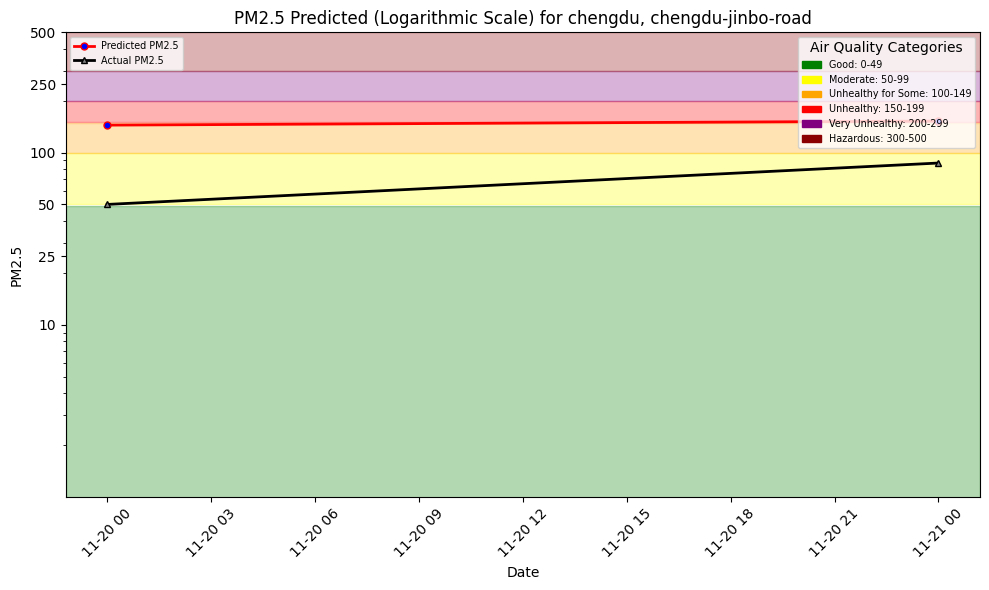

In [29]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---